In [1]:
from codvidutils.utils import load_pictures, adding_images
from codvidutils.imageproc import map_categorical
import numpy as np
import pandas as pd
num_channels= 3
test_class = pd.read_csv('data/test_split_v5.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
X_test = load_pictures(test_class,"data/test/",channels = num_channels)

values_dict = {'COVID-19': 1,'pneumonia': 2,'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_test  = np.asarray(test_class["class_categorical"])
original_test = len(diseaseID_test)
print('shape X: {},  disease_ID (Y): {}'.format(X_test.shape[0],  diseaseID_test.shape[0] ))


shape X: 1525,  disease_ID (Y): 1525


In [2]:
X_test, diseaseID_test = adding_images(X_test, diseaseID_test, strides=5 )
X_test = X_test / 255 
print('shape X: {},  disease_ID (Y): {}'.format(X_test.shape[0],  diseaseID_test.shape[0] ))
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

shape X: 3000,  disease_ID (Y): 3000


In [3]:
val_class = pd.read_csv('data/validation_set.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
X_val = load_pictures(val_class,"data/test/",channels = num_channels)

val_class['class_categorical'] = val_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_val  = np.asarray(val_class["class_categorical"])
#X_val = X_val[:,10:190,10:190,:]
X_val, diseaseID_val = adding_images(X_val, diseaseID_val, strides=10 )
X_val = X_val / 255

Y_val = np.copy(diseaseID_val)
Y_val[Y_val==2]=0
print('shape X: {},  disease_ID (Y): {}'.format(X_val.shape[0],  diseaseID_val.shape[0] ))

shape X: 60,  disease_ID (Y): 60


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow.keras

model = load_model("Inc2uncALL_ADD.hdf5")
p_val = model.predict(X_val)

In [26]:
X_rand = np.random.rand(1000,180,180,3)

In [28]:
from tensorflow.keras.models import load_model
import tensorflow.keras

model = load_model("Inc2uncALL_ADD.hdf5")
p_rand=[]
for i in range(10):
    p_rand += [model.predict(X_rand)]

In [ ]:
probs += [model.predict(X_test)]
probs += [model.predict(X_test)]

In [30]:
p_rand = np.array(p_rand)
p_rand = np.reshape(p_rand,[10,1000])
p_rand.shape

(10, 1000)

In [ ]:
probs = np.array(probs)
probs = np.reshape(probs,[14,3000])
probs.shape

In [ ]:
p_val.shape
np.savetxt("Inc2uncALL_ADD_val60.txt", p_val)
np.savetxt("Inc2uncALL_ADD_14test.txt", probs)

In [4]:
del X_test, X_val
"""
Restart the kernel and don't run the cells with the model.

"""
probs = np.loadtxt("Inc2uncALL_ADD_14test.txt")
p_val = np.loadtxt("Inc2uncALL_ADD_val60.txt")

In [5]:
predictive_mean = np.mean(probs, axis=0)
predictive_variance = np.var(probs, axis=0)
print(predictive_mean.shape)

(3000,)


In [31]:
predictive_mean = np.mean(p_rand, axis=0)
predictive_variance = np.var(p_rand, axis=0)
print(predictive_mean.shape)
Mean_rand = predictive_mean 
Unce_rand  = np.sqrt(predictive_variance)

(1000,)


In [6]:
from sklearn.metrics import mean_squared_error
e_2 = mean_squared_error(Y_val, p_val)
print(np.sqrt(e_2))

0.1451794957972927


In [6]:
Mean = predictive_mean 
Unce  = np.sqrt(predictive_variance)
print("******* MEAN values ******")
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)
print("******* ORIGINAL images ******")
cm = confusion_matrix(Y_test[:original_test], Mean[:original_test].round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

print("******* ADDED images ******")
cm = confusion_matrix(Y_test[original_test:], Mean[original_test:].round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

******* MEAN values ******
[[1363  103]
 [ 513 1021]] 
 [[0.92974079 0.07025921]
 [0.33441982 0.66558018]]
******* ORIGINAL images ******
[[1363  103]
 [  23   36]] 
 [[0.92974079 0.07025921]
 [0.38983051 0.61016949]]
******* ADDED images ******
[[  0   0]
 [490 985]] 
 [[0.         0.        ]
 [0.33220339 0.66779661]]


In [7]:
cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)
print("Mean")
cm = confusion_matrix(Y_test, Mean.round())
print(cm)

print("Mean+ Unc")
cm = confusion_matrix(Y_test, (Mean+Unce).round())
print(cm)

print("Mean- Unc")
cm = confusion_matrix(Y_test, (Mean-Unce).round())
print(cm)

[[1363  103]
 [ 513 1021]] 
 [[0.92974079 0.07025921]
 [0.33441982 0.66558018]]
Mean
[[1363  103]
 [ 513 1021]]
Mean+ Unc
[[1267  199]
 [ 305 1229]]
Mean- Unc
[[1423   43]
 [ 731  803]]


In [8]:
print(" Example values")
print("Normal people")
for p, u in zip(Mean[diseaseID_test==0][:5],Unce[diseaseID_test==0][:5]):
    print(p, "+/- ", u)
print("Neumonia")
for p, u in zip(Mean[diseaseID_test==2][:5],Unce[diseaseID_test==2][:5]):
    print(p, "+/- ", u)
print("COVID-19")
for p, u in zip(Mean[diseaseID_test==1][:5],Unce[diseaseID_test==1][:5]):
    print(p, "+/- ", u)

 Example values
Normal people
0.152753939053842 +/-  0.06573393496985706
0.048027815496815104 +/-  0.030321030791244208
0.4392763280442783 +/-  0.1586530958112596
0.29251833925289766 +/-  0.24299003467981578
0.053211220274014134 +/-  0.0655230050346757
Neumonia
0.02103836026591515 +/-  0.03748324906911875
0.01544683900803128 +/-  0.014856204066366263
0.4294019990733692 +/-  0.2051602192820229
0.12292819483471769 +/-  0.11303259046395771
0.009968219374838685 +/-  0.009247146719639571
COVID-19
0.016736002480164252 +/-  0.026840879186636565
0.0026337588420314467 +/-  0.004150588852814355
0.9132723978587559 +/-  0.08383099811159006
0.7341468312910625 +/-  0.24616875118788356
0.9866890779563359 +/-  0.0151299871406193


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

testScoreECM = 0
testScoreEAM = 0

for pred in probs:
    testScoreECM += mean_squared_error(Y_test, pred)
    testScoreEAM += mean_absolute_error(Y_test, pred)

testScoreECM = testScoreECM/len(probs)
testScoreEAM = testScoreEAM/len(probs)

varECM = 0
varEAM = 0

for pred in probs:
    varECM += (mean_squared_error(Y_test, pred)-testScoreECM)**2
    varEAM += (mean_absolute_error(Y_test, pred)-testScoreEAM)**2

varECM = (varECM/len(probs))**(0.5)
varEAM = (varEAM/len(probs))**(0.5)

print('Mean ECM: %.4f' % (testScoreECM))
print('Mean EAM: %.4f' % (testScoreEAM))
print('variance ECM: %.4f' % (varECM))
print('variance EAM: %.4f' % (varEAM))

In [10]:
def integraciones(integ, nbins,A, B):
    from scipy.integrate import quad
    from numpy import inf
    intervalos = np.linspace(0,1, nbins+1)
    intervalos[0], intervalos[-1] =-inf, inf
    
    proba = np.ones([1,len(intervalos)-1])
    for j in range(len(A)):
        probabilidad = []
        for it in range(len(intervalos)-1):

            I = quad(integ,intervalos[it], intervalos[it+1], args = (A[j], B[j]) )
            probabilidad += [I]

        probabilidad = np.array(probabilidad)[:,0]
        probabilidad = probabilidad.reshape([1,len(intervalos)-1])

        proba = np.concatenate([proba,probabilidad],axis=0)
        
    probability = proba[1:]
    counts = np.sum(probability,axis = 0)
    variance = np.multiply(probability,(1- probability))
    variance = np.sum(variance,axis=0)
    uncounts = np.sqrt(variance)
    return counts, uncounts
def integ(x,m,d):
    from math import pi, sqrt, exp
    return 1 / ( sqrt(2 * pi) * d) * exp(-(m-x)**2 / (2 * d**2))
def integ_not(x,m,d):
    from math import pi, sqrt, exp
    return  exp(-(m-x)**2 / (2 * d**2))

In [15]:
def get_counts(mean, unce, nbins):
    import numpy as np
    from scipy.stats import norm
    bins = np.linspace(0,1,nbins+1)
    bins[0]= -np.inf
    bins[-1]= np.inf
    probability = np.zeros([mean.shape[0], nbins])

    for i in range(mean.shape[0]):
        for j in range(nbins):
            probability[i,j] = (norm.cdf(bins[j+1],loc=mean[i],scale=unce[i])-norm.cdf(bins[j],loc=mean[i],scale=unce[i]))
    
    counts = np.sum(probability,axis = 0)
    variance = np.multiply(probability,(1- probability))
    variance = np.sum(variance,axis=0)
    uncounts = np.sqrt(variance)
    return counts, uncounts

In [13]:
def get_counts(Pred, Upre, true_Y,nbins, label):
    import numpy as np
    from scipy.stats import norm
    mean = Pred[true_Y == label]
    unce = Upre[true_Y == label]
    bins = np.linspace(0,1,nbins+1)
    #bins[0]= -np.inf
    #bins[-1]= np.inf
    probability = np.zeros([mean.shape[0], nbins])

    for i in range(mean.shape[0]):
        for j in range(nbins):
            probability[i,j] = (norm.cdf(bins[j+1],loc=mean[i],scale=unce[i])-norm.cdf(bins[j],loc=mean[i],scale=unce[i]))
    
    counts = np.sum(probability,axis = 0)
    variance = np.multiply(probability,(1- probability))
    variance = np.sum(variance,axis=0)
    uncounts = np.sqrt(variance)
    return counts, uncounts

In [12]:
def get_counts_by_class(Pred,Upre, true_Y, nbins):
    from numpy import unique, linspace
    dic_counts = {0: [], 1:[],2:[] }
    dic_uncounts = {0: [], 1:[],2:[] }
    
    
    for label in unique(true_Y):
        Mean = Pred[true_Y == label]
        Unce = Upre[true_Y == label]
        dic_counts[label], dic_uncounts[label] = get_counts(Mean,Unce,nbins,)

    bins = linspace(0,1,nbins+1)
    return dic_counts, dic_uncounts, bins

In [22]:
from scipy import stats

int_c_40,  unc_c_40 = integraciones(integ,40, Mean[Y_test==1], Unce[Y_test==1] )
int_n_30,  unc_n_30 = integraciones(integ,30, Mean[Y_test==0], Unce[Y_test==0] )
int_n_40,  unc_n_40 = integraciones(integ,40, Mean[Y_test==0], Unce[Y_test==0] )
int_c_30,  unc_c_30 = integraciones(integ,30, Mean[Y_test==1], Unce[Y_test==1] )


In [48]:
int_3n_40,  unc_3n_40 = integraciones(integ,40, Mean[diseaseID_test==0], Unce[diseaseID_test==0] )
int_3p_40,  unc_3p_40 = integraciones(integ,40, Mean[diseaseID_test==2], Unce[diseaseID_test==2] )
int_3n_30,  unc_3n_30 = integraciones(integ,30, Mean[diseaseID_test==0], Unce[diseaseID_test==0] )
int_3p_30,  unc_3p_30 = integraciones(integ,30, Mean[diseaseID_test==2], Unce[diseaseID_test==2] )

In [32]:
coun_rand, uncer_rand = get_counts(Mean_rand, Unce_rand, nbins=40)
dic_counts_3I, dic_variance_3I, binsI = get_counts_by_class(Mean,Unce, diseaseID_test, nbins=40)

In [59]:
np.sum(dic_counts_2_inf[0])

1466.0000000000018

In [61]:
dic_counts_3_inf, dic_variance_3_inf, bins = get_counts_by_class(Mean,Unce, diseaseID_test, nbins=70)
for i in range(3):
    print(np.sum(dic_counts_3_inf[i]), "----", np.sum(dic_variance_3_inf[i]))

0.0
(880, 70)
1.0
(1534, 70)
2.0
(586, 70)
879.9999999999998 ---- 153.64137505035598
1534.0 ---- 281.91891098453124
586.0000000000001 ---- 137.62064118096424


In [17]:
unc_covid = {}
unc_norma = {}
unc_pneum = {}
for i in range(20):
    counts, uncer_3, bins = get_counts_by_class(Mean,Unce, diseaseID_test, nbins=(5*i+5))
    print(i)
    unc_covid[i] = uncer_3[1]
    unc_norma[i] = uncer_3[0]
    unc_pneum[i] = uncer_3[2]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [42]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'
#mpl.rcParams['xtick.labelsize'] = 'XX-large'
#mpl.rcParams['ytick.labelsize'] = 'XX-large'
#mpl.rcParams['axes.labelsize'] = 'XX-large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['font.size'] = '16'

In [18]:
means = np.zeros([3,20])
sums = np.zeros([3,20])
for i in range(20):
    means[1,i] = np.mean(unc_covid[i])
    sums[1,i] = np.sum(unc_covid[i])
    means[0,i] = np.mean(unc_norma[i])
    sums[0,i] = np.sum(unc_norma[i])
    means[2,i] = np.mean(unc_pneum[i])
    sums[2,i] = np.sum(unc_pneum[i])

In [79]:
means[1]

array([10.7087397 ,  8.9850434 ,  7.81596681,  6.99962637,  6.38937293,
        5.91242434,  5.52734245,  5.20837281,  4.93878316,  4.70717884,
        4.50545856,  4.32769484,  4.169465  ,  4.02741301,  3.89894739,
        3.7820304 ,  3.67503153,  3.57662582,  3.48572244,  3.40141349])

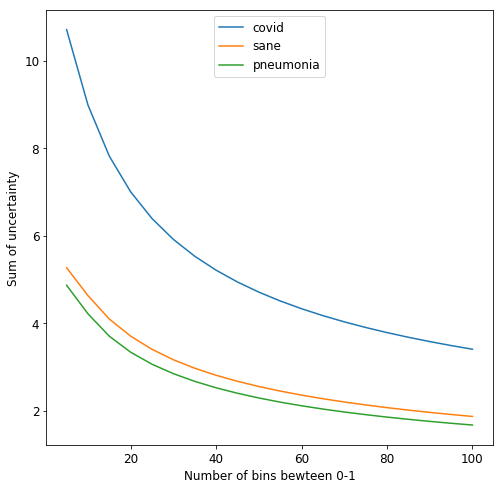

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
hist_bins =  np.linspace(0,1,61)

plt.plot(np.arange(20)*5 + 5, means[1], label="covid")

plt.plot(np.arange(20)*5 + 5, means[0], label="sane")
plt.plot(np.arange(20)*5 + 5, means[2], label="pneumonia")

plt.ylabel("Sum of uncertainty")
plt.xlabel('Number of bins bewteen 0-1')

plt.legend(loc="upper center")

In [47]:
#np.sum(dic_variance_3_inf[1])
np.sum(unc_n_40)

150.95528348875743

ValueError: shape mismatch: objects cannot be broadcast to a single shape

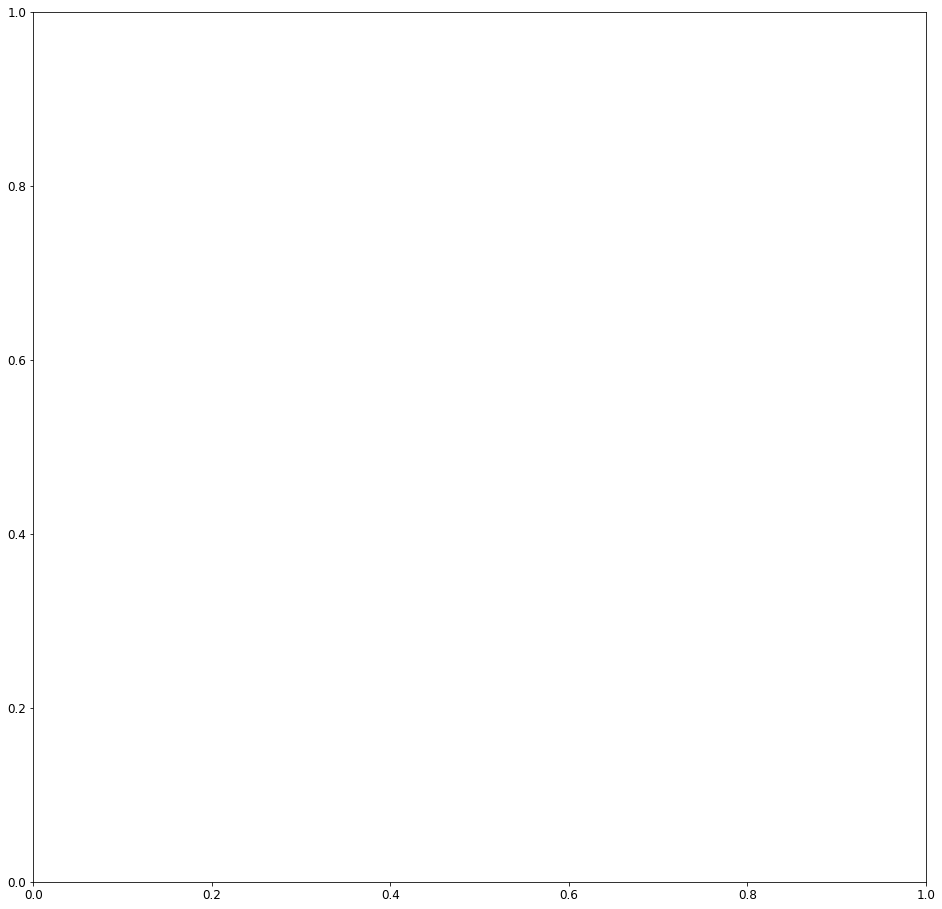

In [54]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,16))# 6,6
from codvidutils.utils import hist_with_unce

plt.style.use('seaborn-deep')
#plt.fill_between(nbins, dic_counts_2[0]-dic_variance_2[0], dic_counts_2[0]+dic_variance_2[0],color='0.75')

#hist_with_unce(hist_bins,dic_counts_3I[1],dic_variance_3I[1],
               #color1="blue", color2="lightblue",lw=2,label ="Julia INF "+ str(np.sum(dic_counts_3_inf[1])))

plt.errorbar(hist_bins[1:], dic_counts_2I[2] ,fmt=" ",marker='.',
             yerr=dic_variance_2I[2],lw=2, color="darkgreen", label = "Original "+str(np.sum(dic_counts_2I[2])))
plt.errorbar(hist_bins[:-1], dic_counts_2_inf[2] ,fmt=" ",marker='.', 
             yerr=dic_variance_2_inf[2],lw=2, color="blue",label ="Or. inf" + str(np.sum(dic_counts_2_inf[2])))
plt.errorbar(bins[:-1], int_n_40 ,fmt=" ",marker='.', 
             yerr=unc_n_30,lw=2, color="orange",label ="Integ " + str(np.sum(int_n_30)))
plt.hist(Mean[Y_test==2],40, color= "black",histtype='step', lw=2,label = "Hist. of mean")
plt.ylabel('Number of counts')
#hist_with_unce(hist_bins,int_c_40,unc_c_40,color1='blue', color2="lightblue",lw=3,label ="Inaki " + str(np.sum(int_c_40)))
#hist_with_unce(hist_bins,dic_counts_3I[1],dic_variance_3I[1],
               #color1='green', color2="lightgreen",lw=2,label ="Julia "+ str(np.sum(dic_counts_3I[1])))

plt.xlabel('Score')
plt.title("Covid # bins = 40")
plt.legend(loc="upper center")
plt.savefig("hist__pneu_julia_vs_inaki_60.eps")

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,16))# 6,6
hist_bins =  np.linspace(0,1,61)

plt.style.use('seaborn-deep')
#plt.fill_between(nbins, dic_counts_2[0]-dic_variance_2[0], dic_counts_2[0]+dic_variance_2[0],color='0.75')


plt.errorbar(bins, dic_counts_3[0] ,fmt=" ",marker='.', yerr=dic_variance_3[0],lw=2, color="darkgreen")
plt.hist(Mean[Y_test==0],60, color= "black",histtype='step', lw=2,label = "Hist. of mean")
plt.ylabel('Number of counts')
hist_with_unce(hist_bins,int_n,unc_n,color1='blue', color2="lightblue",lw=2,label ="Inaki " + str(np.sum(int_n)))
hist_with_unce(hist_bins,dic_counts_3[0],dic_variance_3[0],
               color1='green', color2="lightgreen",lw=2,label ="Julia "+ str(np.sum(dic_counts_3[0])))
hist_with_unce(hist_bins,dic_counts_3I[0],dic_variance_3I[0],
               color1='red', color2="red",lw=2,label ="Julia INF "+ str(np.sum(dic_counts_3I[0])))

plt.xlabel('Score')
plt.title(" No Covid # bins = 60")
plt.legend(loc="upper center")
#plt.savefig("hist_no_covid_julia_vs_inaki_60.eps")

In [51]:
def hist_with_unce (hist_bins, counts, uncer_counts, color1, color2,lw=2, label = None, alpha = 0.5):
    import matplotlib.pyplot as plt
    """
    hist_bins: array with the bin edges, (N+1)-array
    counts: N-array with the value of each bin
    uncer_counts: N-array with the uncertainty of each count.
    color1: color to histogram 
    color2: color to uncertainty area
    lw: lenght of histogram line
    label:
    alpha: transparency of the uner
    """
    plt.hist(hist_bins[:-1], hist_bins, weights = counts,histtype="step",color=color1,lw=lw,label =label)
    for i in range(counts.shape[0]):
        plt.fill_between(hist_bins[i:i+2], counts[i]-uncer_counts[i],counts[i]+uncer_counts[i], color=color2, alpha=0.5)


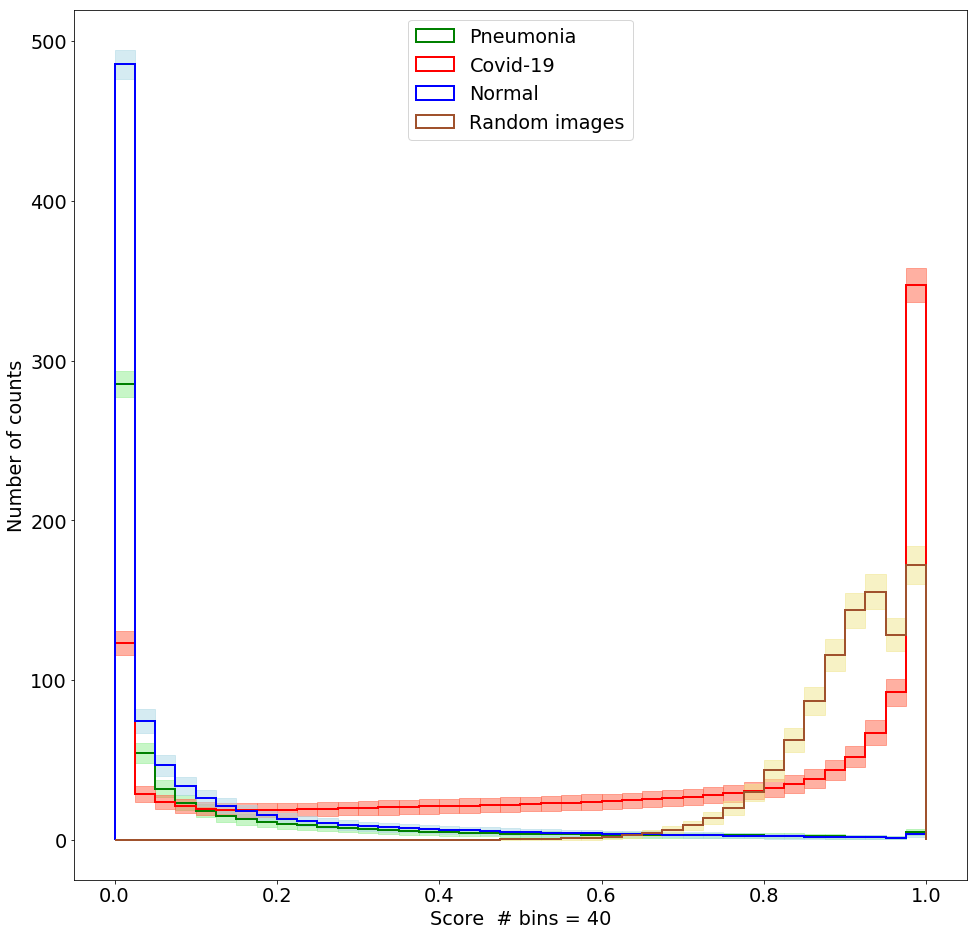

In [53]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,16))# 6,6
#from codvidutils.utils import hist_with_unce
plt.style.use('seaborn-deep')
plt.ylabel('Number of counts')
hist_with_unce(binsI,dic_counts_3I[2],dic_variance_3I[2],
               color1='green', color2="lightgreen",lw=2,label ="Pneumonia")
hist_with_unce(binsI,dic_counts_3I[1],dic_variance_3I[1],
               color1='red', color2="tomato",lw=2,label ="Covid-19")
hist_with_unce(binsI,dic_counts_3I[0],dic_variance_3I[0],
               color1='blue', color2="lightblue",lw=2,label ="Normal")
hist_with_unce(binsI,coun_rand, uncer_rand,
               color1='sienna', color2="khaki",lw=2,label ="Random images")

plt.xlabel("Score  # bins = 40")
plt.ylabel("Number of counts")

plt.legend(loc="upper center")
#plt.savefig("hist_no_covid_julia_vs_inaki_60.eps")

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
hist_bins =  np.linspace(0,1,21)

plt.style.use('seaborn-deep')
plt.hist(hist_bins[:-1], hist_bins, weights =int_n,histtype='step',color='blue',
         lw=4,label ="Inaki " + str(np.sum(int_n)))
#plt.fill_between(nbins, dic_counts_2[0]-dic_variance_2[0], dic_counts_2[0]+dic_variance_2[0],color='0.75')

plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_2[0],histtype='step',
         color='darkorange',lw=2,label ="Julia "+ str(np.sum(dic_counts_2[0])))
plt.errorbar(nbins, int_n ,fmt=" ",marker='.', yerr=unc_n,lw=2, color="blue")
plt.errorbar(nbins, dic_counts_2[0] ,fmt=" ",marker='.', yerr=dic_variance_2[0],lw=2, color="darkorange")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.title("Covid # bins = 20")
plt.legend(loc="upper center")
plt.savefig("hist_no_covid_julia_vs_inaki.eps")

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
hist_bins =  np.linspace(0,1,21)

plt.style.use('seaborn-deep')
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_2[0],histtype='step',color='blue',lw=2,label ="No Covid")
#plt.fill_between(nbins, dic_counts_2[0]-dic_variance_2[0], dic_counts_2[0]+dic_variance_2[0],color='0.75')

plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_2[1],histtype='step',color='darkorange',lw=2,label ="Covid")
plt.errorbar(nbins, dic_counts_2[0] ,fmt=" ",marker='.', yerr=dic_variance_2[0],lw=2, color="blue")
plt.errorbar(nbins, dic_counts_2[1] ,fmt=" ",marker='.', yerr=dic_variance_2[1],lw=2, color="darkorange")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.title("Histogram with errorbar # bins = 20")
plt.legend(loc="upper center")
plt.savefig("hist_error_60.eps")

In [ ]:
nbins

In [ ]:
hist_bins

In [ ]:
bins

In [ ]:
filled_bins  = bins - (nbins[1]-nbins[0])/2
filled_bins[0] = 0
filled_bins = np.append(filled_bins,1)
filled_bins

In [ ]:
(dic_counts_3[0]-dic_variance_3[0])[0]

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
hist_bins =  np.linspace(0,1,61)

plt.style.use('seaborn-deep')
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[0],histtype='step',color='blue',lw=2,label ="No Covid")
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[1],histtype='step',color='#ED760E',lw=2,label ="Covid")
for i in range(bins.shape[0]):
    plt.fill_between(hist_bins[i:i+2], (dic_counts_3[0]-dic_variance_3[0])[i], 
                 (dic_counts_3[0]+dic_variance_3[0])[i], color='lightblue')
    plt.fill_between(hist_bins[i:i+2], (dic_counts_3[1]-dic_variance_3[1])[i], 
                 (dic_counts_3[1]+dic_variance_3[1])[i], color='#FFA420')

#plt.plot(bins_fill, dic_counts_2[0], color= "black")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.title("Histogram with error square # bins = 60")
plt.legend(loc="upper center")
plt.savefig("hist_error_square_60.eps")

In [23]:
def hist_with_unce (hist_bins, counts, uncer_counts, color1, color2,lw=2, label = None, histtype = "step"):
    import matplotlib.pyplot as plt
    """
    hist_bins: array with the bin edges, (N+1)-array
    counts: N-array with the value of each bin
    uncer_counts: N-array with the uncertainty of each count.
    """
    plt.hist(hist_bins[:-1], hist_bins, weights = counts,histtype=histtype,color=color1,lw=lw,label =label)
    for i in range(counts.shape[0]):
        plt.fill_between(hist_bins[i:i+2], counts[i]-uncer_counts[i],counts[i]+uncer_counts[i], color=color2)

    

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
hist_bins =  np.linspace(0,1,21)

plt.style.use('seaborn-deep')
hist_with_unce(hist_bins,dic_counts_2[0],dic_variance_2[0],color1='blue', color2="lightblue",lw=2,label ="No Covid")
hist_with_unce(hist_bins,dic_counts_2[1],dic_variance_2[1],color1='orange', color2="red",lw=2,label ="Covid")
#plt.plot(bins_fill, dic_counts_2[0], color= "black")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.title("Histogram with error square # bins = 20")
plt.legend(loc="upper center")
plt.savefig("hist_error_square_20.eps")

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
hist_bins =  np.linspace(0,1,61)

plt.style.use('seaborn-deep')
"""
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[0]+dic_variance_3[0],histtype='barstacked',color='lightblue')#,lw=5,label ="No Covid")
#
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[0]-dic_variance_3[0],histtype='bar',color='white',lw=1)
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[0],histtype='step',color='blue',lw=2,label ="No Covid")

plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[1]+dic_variance_3[1],histtype='barstacked',color='orange')#,lw=5,label ="No Covid")
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[1]-dic_variance_3[1],histtype='bar',color='white',lw=1)
"""
plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[0],histtype='step',color='blue',lw=2,label ="No Covid")

plt.hist(hist_bins[:-1], hist_bins, weights = dic_counts_3[1],histtype='step',color='darkorange',lw=2,label ="Covid")

plt.errorbar(bins, dic_counts_3[0] ,fmt=" ",marker='.', yerr=dic_variance_3[0],lw=2, color="blue")
plt.errorbar(bins, dic_counts_3[1] ,fmt=" ",marker='.', yerr=dic_variance_3[1],lw=2, color="darkorange")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.title("Histogram with error square # bins = 60")
plt.legend(loc="upper center")
plt.savefig("hist_erorr_60.eps")

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.errorbar(bins, dic_counts_3[0] ,fmt=" ",marker='.', yerr=dic_variance_3[0],lw=2, color="blue",label ="No Covid")
plt.errorbar(bins, dic_counts_3[1] ,fmt=" ",marker='.', yerr=dic_variance_3[1],lw=2, color="darkorange",label ="Covid")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.title("Points with errorline # bins = 60")
plt.legend(loc="upper center")
plt.savefig("points_error_60.eps")

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.errorbar(nbins, dic_counts_2[0] ,fmt=" ",marker='.', yerr=dic_variance_2[0],lw=2, color="blue",label ="No Covid")
plt.errorbar(nbins, dic_counts_2[1] ,fmt=" ",marker='.',yerr=dic_variance_2[1],lw=2, color="darkorange",label ="Covid")
plt.ylabel('Number of counts')

plt.xlabel('Score')
plt.title("Points with errorline #bins = 20")
plt.legend(loc="upper center")
plt.savefig("points_error_20.eps")

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.plot(bins, dic_counts_3[0],lw=2, color="blue",label ="Normal")
plt.fill_between(bins, dic_counts_3[0]-dic_variance_3[0], dic_counts_3[0]+dic_variance_3[0],color='0.75')
#plt.errorbar(bins, dic_counts_2[0] ,fmt=" ",marker='.', yerr=dic_variance_2[0],lw=1, color="darkorange",label ="Covid")
#plt.errorbar(bins, dic_counts_3[2] ,fmt=" ",marker='.', yerr=dic_variance_3[2],lw=1, color="red",label ="Pneumonia")
plt.plot(bins, dic_counts_3[1],lw=2, color="darkorange",label ="Covid")
plt.fill_between(bins, dic_counts_3[1]-dic_variance_3[1], dic_counts_3[1]+dic_variance_3[1],color='orange')
plt.title("Line with errorband #bins = 60")
plt.savefig("line_error_60.eps")

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.plot(nbins, dic_counts_2[0],lw=1, color="blue",label ="Normal")
plt.fill_between(nbins, dic_counts_2[0]-dic_variance_2[0], dic_counts_2[0]+dic_variance_2[0],color='0.75')
#plt.errorbar(bins, dic_counts_2[0] ,fmt=" ",marker='.', yerr=dic_variance_2[0],lw=1, color="darkorange",label ="Covid")
#plt.errorbar(bins, dic_counts_3[2] ,fmt=" ",marker='.', yerr=dic_variance_3[2],lw=1, color="red",label ="Pneumonia")
plt.plot(nbins, dic_counts_2[1],lw=1, color="darkorange",label ="Covid")
plt.fill_between(nbins, dic_counts_2[1]-dic_variance_2[1], dic_counts_2[1]+dic_variance_2[1],color='orange')
plt.title("Line with errorband #bins = 20")
plt.savefig("line_error_20.eps")

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.errorbar(bins, dic_counts_3[0] ,fmt=" ",marker='.', yerr=dic_variance_3[0],lw=1, color="blue",label ="Normal")
plt.errorbar(bins, dic_counts_3[1] ,fmt=" ",marker='.', yerr=dic_variance_3[1],lw=1, color="darkorange",label ="Covid")
plt.errorbar(bins, dic_counts_3[2] ,fmt=" ",marker='.', yerr=dic_variance_3[2],lw=1, color="red",label ="Pneumonia")
#plt.hist(Mean[(diseaseID_test==2)],50,histtype='step',color='blue',lw=2,label= "No covid" )
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
#plt.savefig(filename)

In [ ]:
Upper = Mean + Unce
Upper[Upper>1] = 1
Upper[Upper<0] = 0
Lower = Mean - Unce
Lower[Lower>1] = 1
Lower[Lower<0] = 0

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, Mean)
fpr_U, tpr_U, thr = roc_curve(Y_test,Upper)
fpr_L, tpr_L, thr = roc_curve(Y_test,Lower)
roc_auc = auc(fpr,tpr)
roc_auc_U = auc(fpr_U,tpr_U)
roc_auc_L = auc(fpr_L,tpr_L)
print(roc_auc, roc_auc_L, roc_auc_U)

In [ ]:
for f in fpr_L:
    print(f, f in fpr_U)

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
#plt.title("Simulation", weight="bold", x=0.50)
plt.grid(True)
#yticks(np.arange(0.97, 1, step=0.005))
lw = 2
plt.plot(fpr, tpr, color='orange',lw=2, label='ROC-curve (AUC = %0.3f)' % (roc_auc))
plt.plot(fpr_U, tpr_U, color='blue',lw=1, label='ROC-curve Upper (AUC = %0.3f)' % (roc_auc_U))
plt.plot(fpr_L, tpr_L, color='blue',lw=1, label='ROC-curve Lower (AUC = %0.3f)' % (roc_auc_L))
#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')


plt.ylabel('True Positie Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

#plt.title("Simulation Preliminary", color = '#e159e1',loc="left", weight="bold", size="large")
plt.legend(loc="lower left")
plt.show()